## Task 0 (Know your Data) - Exploratory Data Analysis

## 0.1. Loading Data

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import neighbors, tree, preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB

In [54]:
df = pd.read_csv('PetFinder_dataset.csv')

Loading colour, breed and state labels:

In [5]:
color_labels = pd.read_csv('color_labels.csv').set_index('ColorID')
breed_labels = pd.read_csv('breed_labels.csv').set_index('BreedID')
state_labels = pd.read_csv('state_labels.csv').set_index('StateID')

## 0.2. Understanding Data

### Basic Questions

#### How big is the dataset?
The dataset contains 14993 entries with 24 features each.

#### Is this the entire dataset?
The original dataset from PetFinder.my contains over 150,000 animal profiles.

#### Is this data representative enough?
The dataset represents ~10% of the original data. EDA is required to best assess whether it can be considered a representative sample of the original population.

#### Are there likely to be gross outliers or extraordinary sources of noise?
EDA can shed light on this topic, by representing data distribution and irregularities that could point to errors in data.

#### Are there any fields that are unique identifiers? These are the fields you might use for joining between datasets, etc.
All animal profiles are uniquely identified by a PetID. Each PetID also has a non-unique RescuerID, and a non-unique State.

#### Are the supposedly unique identifiers actually unique? What does it mean if they aren't?
PetID.

#### When data entries are blank, where does that come from?
The only blank entries in this dataset correspond to animal profiles without an assigned name.

#### How common are blank entries?
There are ~1200 blank entries, which constitute a significant portion of the data. Given this number, and due to the fact that blank entries have meaning attributed to them, it would perhaps be best to keep this data in the dataset for analysis.

### Exploratory Data Analysis

In order to better understand our dataset and to make decisions about feature selection, feature extraction and general cleaning of the data, we started by plotting distribution of the original features and the target.

#### Target: *AdoptionSpeed*

The target feature displayed a clear discrepancy in distribution, showing a significantly lower number of examples for AdoptionSpeed = 0. This imbalance should be addressed, as models tend to neglect minority classes if they don't have a large enough representation in the overall dataset, therefore compromising the classification.

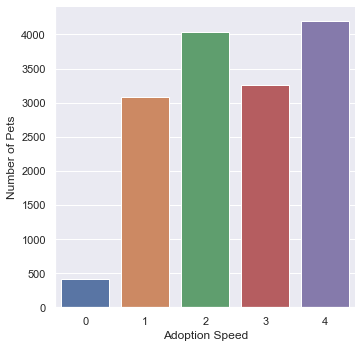

In [63]:
ax = sns.catplot(x="AdoptionSpeed",data=df, kind='count')
(ax.set_axis_labels("Adoption Speed", "Number of Pets"))

#### Type

Because we are going to later create type-specific predictive models, it would be relevant to see the number of cases we have in our dataset for each animal (cat or dog).

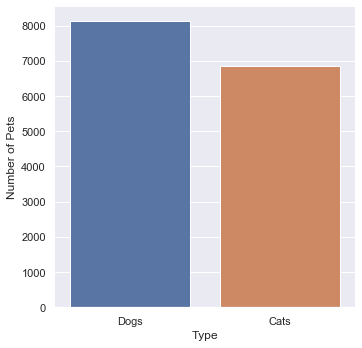

In [64]:
bx = sns.catplot(x="Type",data=df, kind='count')
(bx.set_axis_labels("Type", "Number of Pets")
    .set_xticklabels(["Dogs", "Cats"])
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

Looking at our data, we conclude the number of examples is fairly proportional, as well as their distribution relative to the target class, making the resulting models' performance more comparable.

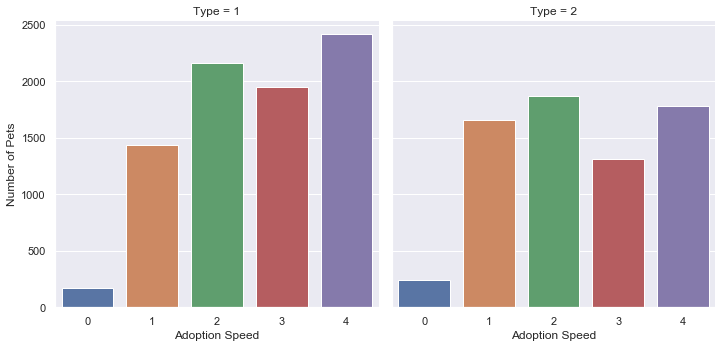

In [65]:
cx = sns.catplot(x="AdoptionSpeed",col="Type",data=df, kind='count')
(cx.set_axis_labels("Adoption Speed", "Number of Pets"))

#### Age

When looking at the Age distribution, we can see that there are peaks every 12 months. Young pets (less than 1 year old) are the most frequent.

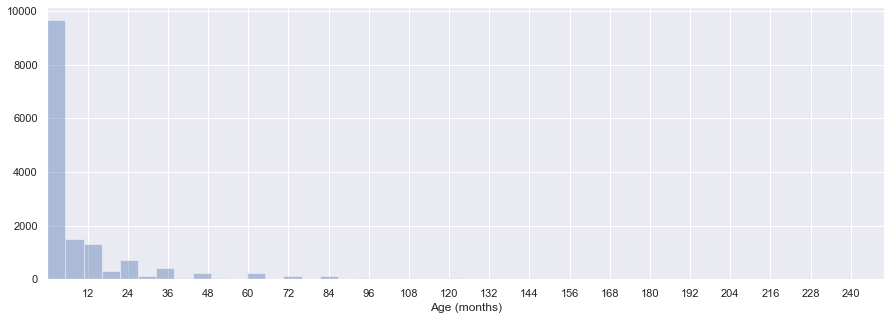

In [4]:
a = df['Age'] # get Age array
nr_bins = 1 + 3.322*math.log(len(a),2) # Number of bins according to Sturges rule
sns.set(rc={'figure.figsize':(15,5)}) # set figure size

# setting up the axis
fig, ax = plt.subplots()
ticks = [i for i in range(0,260,12)]
ticks.pop(0)
ax.set_xticks(ticks)
plt.xlim([0.0,250])

sns.distplot(a, bins=round(nr_bins), kde=False, axlabel="Age (months)");

The average cat is considered a kitten roughly until it reaches the age of 1 year old. The same goes for puppies. On the other hand, dogs and cats are considered Seniors roughly when they reach the age of 6 years. Of course, these are approximations, as the classification varies with the type of animal (cats or dogs), breed, size and many other factors.

In this sense, we will consider these categories:
* Baby - age 0-11 months
* Adult - age 12-71 months
* Senior - age 72-250 months

#### Breed1 and Breed2

According to the breeds feature labels, dogs breeds go from 1 to 240, plus 307, and cats breeds go from 241 to 306. 

In [ ]:
bx1 = sns.catplot(x="Breed1",data=df, kind='count',height=9, aspect=3)
bx2 = sns.catplot(x="Breed2",data=df, kind='count',height=9, aspect=3)

Looking at our data, and according to the breeds feature labels, we found some cats with dogs breeds assigned to them (15, 21, 25, 70, 114, 205, 218, 307).
Therefore, and given the distribution of pets by breeds in which some breeds are poorly representated perhaps a good idea should be grouping pets by pure-race/mixed-race. However, we will leave this for further analysis within this project.

#### Color1, Color2 and Color3

Each pet has at least one main color (color1) that according to the colors features label can go from black(1) to white(7). Pets can also have one or two additional colors (color2 and color3) with the same categorical values as the main color.

In [ ]:
zx1 = sns.catplot(x="Color1",col="Type",data=df, kind='count',height=4, aspect=0.8)
(zx1.set_axis_labels("Color 1", "Number of Pets"))
zx2 = sns.catplot(x="Color2",col="Type",data=df, kind='count',height=4, aspect=0.8)
(zx2.set_axis_labels("Color 2", "Number of Pets"))
zx3 = sns.catplot(x="Color3",col="Type",data=df, kind='count',height=4, aspect=0.8)
(zx3.set_axis_labels("Color 3", "Number of Pets"))

Given the number of values for each color feature one of the following approaches should be appropriate to address the Color1, Color2 and Color3 features: 
* Group pets according to the number of colors one has. Pets with only one color will be assigned a "SingleColor" feature and so on;
* Group colours according to their brightness/darkness.

However we will leave further considerations on the feature engineering part later on this document.

#### Maturity Size

XXXXXXXXX

#### Fur Length

XXXXXXXXX

#### Vaccinatted, Dewormed and Sterilized

XXXXXXXXX

In [ ]:
ax11 = sns.catplot(x='Vaccinated', col='Dewormed',row='Sterilized',data=df, kind='count')

#### Quantity

XXXXXXXXX

In [ ]:
ax3 = sns.catplot(x='Quantity', data=df, kind='count')
(ax3.set_axis_labels("Quantity", "Number of Pets"))
print('There are {} profiles with a single pet'.format((list(df['Quantity'])).count(1)))
print('There are {} profiles with multiple pets'.format(len(df['Quantity'])-list(list(df['Quantity'])).count(1)))

#### Fee

XXXXXXXXX

#### State

XXXXXXXXX

In [ ]:
ax13 = sns.catplot(x='State', data=df, kind='count',height=4, aspect=2)
(ax13.set_axis_labels("State", "Number of Pets"))

#### RescuerID

In order to extract some meaning from the 'RescuerID', we decided, as a first approach, to find out whether is frequent for rescuers to save and advertise multiple pets.

In [ ]:
x = list(df['RescuerID'].unique())
y = list(df['RescuerID'])
z = []
t = {}
for i in x:
    z.append( y.count(i))

t['Rescuer'] = x
t['entries'] = z

e = pd.DataFrame(t)
print('There are {} unique rescuers in the dataset'.format(len(x)))
print('There are {} rescuers with only 1 webpage entry in the dataset'.format(z.count(1)))
print('There are {} rescuers with more than 1 webpage entry in the dataset'.format(len(x)-(z.count(1))))
ax11 = sns.catplot(x='entries', data=e, kind='count', height=5, aspect=3)
(ax11.set_axis_labels("Web page entries", "Number of Rescuers")
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

According to the dataset, the number of rescuers with a single entry in the MyPet webpage is greater than the number of rescuers who save and advertise more than 1 pet. This information could be useful on later anaylsis to discover wheter the number of webpage profile entries associated with a rescuer has any interference in pet's apoption or adoption speed.

#### VideoAmt

xxxxxxxxxxxx.

In [ ]:
ax2 = sns.catplot(x='VideoAmt', data=df, kind='count')
(ax2.set_axis_labels("Video Amount", "Number of Pets"))
print('There are {} profiles with 0 videos'.format((list(df['VideoAmt'])).count(0)))
print('There are {} profiles with more than 0 videos'.format(len(df['VideoAmt'])-list(list(df['VideoAmt'])).count(0)))

#### Description

In order to extract some meaning from the 'Description', we decided, as a first approach, to partition this continuous feature into discrete values.

Since empty descriptions (size=0) probably have a direct influence in the adoption choice, it should be a category of its own. For that reason, we exclude empty descriptions from the discretization procces.

We consider that the discretization of the 'description sizes' based on the quantiles strategy is appropriate, since it is plausible to say that the ad writers define what a 'medium' size description is. In that sense, a 'medium' sized description would have the average word count. In analogy, the smallest and largest descriptions would correspond to the first and third quantiles.

Based on these results, we present a new feature 'DescriptionSize' whose possible values include:
* 'Empty' for descriptions containing 0 words
* 'Small' for descriptions containing between 1 and 28 words
* 'Medium' for descriptions containing between 29 and 65 words
* 'Large' for descriptions containing between 66 and 1257 words

#### PetID

Since PetID is not informative of the pet profile (it acts solely as a unique identifier of the page), it would be excluded from the analysis, although it will be used as an index for the dataFrame. It can be later useful when evaluating model performance, as the respective record values can reveal if certain features were appropriately categorised.

In [ ]:
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
import statistics 

l=[]

# List descriptions' lengths (i.e. number of char)
for i in df['Description']:
    if type(i)!=str: # Some empty descriptions are type:float
        l.append(0)
    else:
        l.append(len(i.split()))

mean = statistics.mean(l)
print("The average descripton size:" , mean)

# Histogram
a1 = np.asarray(l)
nr_bins = 1 + 3.322*math.log(len(l),2) # Number of bins according to Sturges rule
a1 = pd.Series(a1)
a1.plot.hist(grid=True, bins = round(nr_bins), rwidth=0.9, color='#607c8e')
plt.title('Description size distribution')
plt.xlabel('Description size (# words)')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

# Discretization by quantile strategy:
a2 = np.asarray(l).reshape(-1,1) # Reshape data since we are working with just one feature
est = preprocessing.KBinsDiscretizer(n_bins=[3],encode='ordinal', strategy='quantile').fit(a2)
decp = est.transform(a2)

print("According to this discretization, the bin edges should be:")
print(est.bin_edges_) # how the data is distributed in the four bins

#### Photo Amt

xxxxxxxxxxxx.

In [ ]:
ax1 = sns.catplot(x='PhotoAmt', data=df, kind='count',height=4, aspect=3)
(ax1.set_axis_labels("Photo Amount", "Number of Pets"))

#### Predictions and hypotheses
Named vs. nameless profiles

Rescuers with higher adoption rates

##### Photos/videos vs. no photos/videos
* **PhotoAmt: No photo vs. photos**
* Analysing the distribution of AdoptionSpeed with regards to PhotoAmt, there is a clear distinction between animals with no photos (which have a higher proportion of AdoptionSpeed = 4) and animals with 1 or more photos (which have a more uniform distribution).

More photos/videos vs. less photos/videos

One animal vs. multiple animals

Cats vs. dogs

Multiple pets for one rescuer vs. one pet for one rescuer (profiles with more than one pet will suggest other pets by the same rescuer; possibly influences users to explore pets of the same rescuer more often)

Free adoption vs. paid adoption

#### Disproportionate data
If data is not represetantive of a specific feature, consider removing it; might skew the analysis of that feature (e.g.: if only a few animals exist in State X and all are adopted, model might conclude all animals in State X are always adopted)

AdoptionSpeed = 0 is less frequent that AdoptionSpeed > 0, but it can reflect the reality of adoption for animais in the website

In this task you should **understand better the features**, their distribution of values, potential errors, etc and plan/describe what data preprocessing steps should be performed next. Very important also is the distribution of values in the target (class distribution). 

Here you can find a notebook with some examples of what you can do in **Exploratory Data Analysis**: https://www.kaggle.com/artgor/exploration-of-data-step-by-step/notebook. You can also use Orange widgets for this.

...

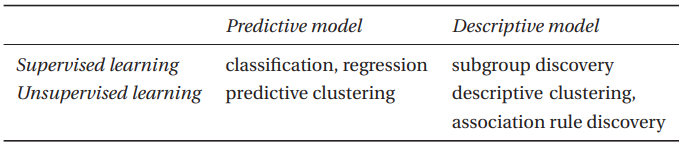

**Task 1** will consist in a supervised learning predictive task.

**Task 2** will consist in an unsupervised learning descriptive task.

## Task 1 (Supervised Learning) - Predicting Adoption and Adoption Speed

In this task you should target 3 classification tasks:
1. **Predicting  Adoption (binary classification task)**: create a new target from AdoptionSpeed that is 1 if AdoptionSpeed <> 4 and 0 otherwise.
2. **Predicting AdoptionSpeed (multiclass classification)**: in this task you should you the original target AdoptionSpeed, whose values are in the set {0, 1, 2, 3 , 4} (5 classes). This is a very difficult problem. You might also want to consider 3 classes (for instance {0-1, 2-3, 4}, or other sets that make sense). 
3. **Train specialized models for cats and dogs**: train with cat/dog instances and check whether the classification performance changes when Predicting Adoption and Predicting AdoptionSpeed.

**You should:**

* Choose **one classifier in each category**: Tree models, Rule models, Linear models, Distance-based models, and Probabilistic models.
* Use cross-validation to evaluate the results. 
* Present and discuss the results for different evaluation measures, present confusion matrices. Remember that not only overall results are important. Check what happens when learning to predict each class.
* Describe the parameters used for each classifier and how their choice impacted or not the results.
* Choose the best classifier and fundament you choice. (Confusion matrices w/ accuracy for various targets)
* **Discuss critically your choices and the results!**

## 1.1. Preprocessing Data for Classification

Data to exclude from datasets:
* PetID (?) --> converted to index

Data to convert:
* Name --> # of characters
* Description (?) --> # of character
* RescuerID (?) --> count
* Breed1 and Breed2 --> Breed (0 if pure, 1 if mixed)

Data to separate:
* Gender = 3, in gender-dependent analysis



#### NAME

Since a reasonable amount of the profiles didn't make any reference no name (where empty) a first approach would be to fill those empty values with a fixed value such "No Name" or similar. 

Other approach would be to transform this feature into a binary one with a 0 value for profiles with no name and a 1 value for the opposite. 

Since it was later found that some of the named profiles were filled with "No Name" and derivatives of this name such as "No Name Yet", etc, we chose, as a first approach to transform the name feature (categorical) into a numerical one by counting the number of letters in each profile.

In [55]:
lista1 = []
for i in df['Name']:
    if type(i)!=str: # Some empty descriptions are type:float
        lista1.append(float(0))
    else:
        lista1.append(float(len(i.split())))
  
df.insert((df.columns.get_loc("Name"))+1,'Name_cnt',lista1) ##INSERT IN DATAFRAME

#### BREEDS

The breeds1 and breeds2 feature are represented by numerical values that represent categorical values. These two features have also many different possible values that don't have any particular order relationship between them. Therefore, and to avoi the encoding of hundreds of values for both breeds1 and breeds2 we decided to create a new binary feature "PureBreed" which gives a value of 0 to the profiles whose pets are mixed a value of 1 to the profiles whose pets are pure breed.

In [56]:
lista3 =[]
for i in range(len(df)):
    if df['Breed1'][i]==307 or df['Breed2'][i]==307:
        lista3.append(0)
    elif df['Breed1'][i]!=307 and df['Breed2'][i]==0:
        lista3.append(1)
    elif df['Breed1'][i]==0 and df['Breed2'][i]!=307:
        lista3.append(1)
    elif df['Breed1'][i]==df['Breed2'][i]:
        lista3.append(1)
    else:
        lista3.append(0)
     
df.insert((df.columns.get_loc("Breed2"))+1,'PureBreed',lista3) ##INSERT IN DATAFRAME

#### RESCUERID

As a first approach we decided to create from the RescuerID a new binary feature (FrequentRescuer) that reflects those profiles who belong to frequent rescuers (profiles who have more than 1 pet advertised on the PetFinder website)

In [57]:
lista2 = []
y = list(df['RescuerID'])
for i in df['RescuerID']:
      if y.count(i)>1:
          lista2.append(float(1))
      else:
          lista2.append(float(0))
          
df.insert((df.columns.get_loc("RescuerID"))+1,'FrequentRescuer',lista2) ##INSERT IN DATAFRAME

#### DESCRIPTION

As a first approach we decided to create from the "Description" a new numerical feature (DescriptionLength) which reflects the number of characters in each profile's description. 

In [58]:
lista4=[]

for i in df['Description']:
    if type(i)!=str:
        lista4.append(float(0))
    else:
        lista4.append(float(len(i.split())))

df.insert((df.columns.get_loc("Description"))+1,'DescriptionLength',lista4) ##INSERT IN DATAFRAME

df = df.drop(['Name','RescuerID','PetID', 'Description', 'Breed1','Breed2'], axis=1)

## 1.2. Learning Classifiers

#### ENCODING

Although most of the features are represented by numerical features they have a categorical meaning. Therefore and encoding was made for the following features:

In [59]:
# ENCODING THE FOLLOWING FEATURES
## TYPE, GENDER, MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,State
encoder = OneHotEncoder()
df_encoded = encoder.fit_transform(df[['Type','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State']]).toarray()
column_name = encoder.get_feature_names(['Type','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'])
one_hot_encoded_frame =  pd.DataFrame(df_encoded, columns= column_name)

print(column_name) #encoded features names

print(one_hot_encoded_frame) #encoded dataframe without the non encoded features

['Type_1.0' 'Type_2.0' 'Gender_1.0' 'Gender_2.0' 'Gender_3.0' 'Color1_1.0'
 'Color1_2.0' 'Color1_3.0' 'Color1_4.0' 'Color1_5.0' 'Color1_6.0'
 'Color1_7.0' 'Color2_0.0' 'Color2_2.0' 'Color2_3.0' 'Color2_4.0'
 'Color2_5.0' 'Color2_6.0' 'Color2_7.0' 'Color3_0.0' 'Color3_3.0'
 'Color3_4.0' 'Color3_5.0' 'Color3_6.0' 'Color3_7.0' 'MaturitySize_1.0'
 'MaturitySize_2.0' 'MaturitySize_3.0' 'MaturitySize_4.0' 'FurLength_1.0'
 'FurLength_2.0' 'FurLength_3.0' 'Vaccinated_1.0' 'Vaccinated_2.0'
 'Vaccinated_3.0' 'Dewormed_1.0' 'Dewormed_2.0' 'Dewormed_3.0'
 'Sterilized_1.0' 'Sterilized_2.0' 'Sterilized_3.0' 'Health_1.0'
 'Health_2.0' 'Health_3.0' 'State_41324.0' 'State_41325.0' 'State_41326.0'
 'State_41327.0' 'State_41330.0' 'State_41332.0' 'State_41335.0'
 'State_41336.0' 'State_41342.0' 'State_41345.0' 'State_41361.0'
 'State_41367.0' 'State_41401.0' 'State_41415.0']
       Type_1.0  Type_2.0  Gender_1.0  Gender_2.0  Gender_3.0  Color1_1.0  \
0           0.0       1.0         1.0         0.0     

C:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [60]:
# INSERT THE NON ENCODED FEATURES IN THE DATAFRAME AGAIN
one_hot_encoded_frame.insert(2,'Name_cnt',df['Name_cnt']) ## NAME_CNT  
one_hot_encoded_frame.insert(3,'Age',df['Age']) ## AGE  
one_hot_encoded_frame.insert(4,'PureBreed',df['PureBreed']) ## PUREBREED    
one_hot_encoded_frame.insert(47,'Quantity',df['Quantity']) ## QUANTITY    
one_hot_encoded_frame.insert(48,'Fee',df['Fee']) ## FEE  
one_hot_encoded_frame.insert(63,'FrequentRescuer',df['FrequentRescuer']) ## FrequentRescuer  
one_hot_encoded_frame.insert(64,'VideoAmt',df['VideoAmt']) ## VideoAmt  
one_hot_encoded_frame.insert(65,'DescriptionLength',df['DescriptionLength']) ## DescriptionLength  
one_hot_encoded_frame.insert(66,'PhotoAmt',df['PhotoAmt']) ## PhotoAmt
one_hot_encoded_frame.insert(67,'AdoptionSpeed',df['AdoptionSpeed']) ## AdoptionSpeed

print(one_hot_encoded_frame) ## data frame for training

       Type_1.0  Type_2.0  Name_cnt  Age  PureBreed  Gender_1.0  Gender_2.0  \
0           0.0       1.0       1.0    3          1         1.0         0.0   
1           0.0       1.0       3.0    1          1         1.0         0.0   
2           1.0       0.0       1.0    1          0         1.0         0.0   
3           1.0       0.0       1.0    4          0         0.0         1.0   
4           1.0       0.0       1.0    1          0         1.0         0.0   
...         ...       ...       ...  ...        ...         ...         ...   
14988       0.0       1.0       0.0    2          1         0.0         0.0   
14989       0.0       1.0       3.0   60          0         0.0         0.0   
14990       0.0       1.0       1.0    2          0         0.0         0.0   
14991       0.0       1.0       2.0    9          1         0.0         1.0   
14992       1.0       0.0       1.0    1          0         1.0         0.0   

       Gender_3.0  Color1_1.0  Color1_2.0  ...  Sta

In [61]:
nc = one_hot_encoded_frame.shape[1]
matrix = one_hot_encoded_frame.values # Convert dataframe to darray
examples = matrix [:, 0:nc-1] # get features 
target = matrix [:, nc-1] # get class (last columns)           
fnames = one_hot_encoded_frame.columns.values[0:nc-1] #get features names
tname = one_hot_encoded_frame.columns.values[nc-1] #get target name

### Predicting Adoption (binary classification task)

Since this is a binary task, the adoptionspeed had to be converted into a binary feature (0 - for profiles with adoptionspeed = 4; 1 for profiles with adoptionspeed < 4)

In [87]:
ex1 = examples
tgt1 = target 
fn1 = fnames
tn1 = tname

## change target feature to be binary
for i in range(len(tgt1)):
    if tgt1[i] < 4:
        tgt1[i]=float(1)
    else:
        tgt1[i]=float(0)

tn1 = 'Adoption' ##change target feature name

ex1 = ex1.astype(float)

print(tn1)
print(ex1)

Adoption
[[ 0.  1.  1. ...  0. 69.  1.]
 [ 0.  1.  3. ...  0. 23.  2.]
 [ 1.  0.  1. ...  0. 69.  7.]
 ...
 [ 0.  1.  1. ...  0.  9.  5.]
 [ 0.  1.  2. ...  0. 18.  3.]
 [ 1.  0.  1. ...  0. 16.  1.]]


In [63]:
## split data frame into test and train sets
X_train, X_test, y_train, y_test = train_test_split(ex1, tgt1, random_state=0)

print(X_train.shape)
print(X_test.shape)

(11244, 67)
(3749, 67)


In [64]:
print("Number of positives cases in the train set is: {}".format(np.count_nonzero(y_train == 1)))
print("Number of negative cases in the train set is: {}".format(np.count_nonzero(y_train == 0)))
print("Ratio positive to negative cases in the training set: {}".format((np.count_nonzero(y_train == 1))/(np.count_nonzero(y_train == 0))))

Number of positives cases in the train set is: 8078
Number of negative cases in the train set is: 3166
Ratio positive to negative cases in the training set: 2.5514845230574856


In [65]:
print("Number of positives cases in the test set is: {}".format(np.count_nonzero(y_test == 1)))
print("Number of negative cases in the test set is: {}".format(np.count_nonzero(y_test == 0)))
print("Ratio positive to negative cases in the test set: {}".format((np.count_nonzero(y_test == 1))/(np.count_nonzero(y_test == 0))))

Number of positives cases in the test set is: 2718
Number of negative cases in the test set is: 1031
Ratio positive to negative cases in the test set: 2.6362754607177497


#### 1. KNN

In [66]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3) ## 3 neighbors for starters
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [67]:
knn = knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)

print("Accuracy on training set:",  knn.score(X_train, y_train))

Accuracy on training set: 0.8313767342582711


In [68]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.58      0.66      3166
         1.0       0.85      0.93      0.89      8078

    accuracy                           0.83     11244
   macro avg       0.81      0.75      0.77     11244
weighted avg       0.83      0.83      0.82     11244



In [69]:
y_test_pred = knn.predict(X_test)

print("Accuracy on test set:",  knn.score(X_test, y_test))

Accuracy on test set: 0.6945852227260603


In [70]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.43      0.32      0.36      1031
         1.0       0.76      0.84      0.80      2718

    accuracy                           0.69      3749
   macro avg       0.59      0.58      0.58      3749
weighted avg       0.67      0.69      0.68      3749



Text(0.5, 1, 'Confusion Matrix - Train Set')

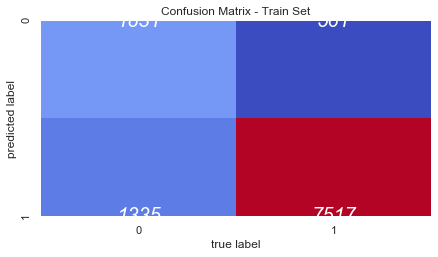

In [71]:
cm_test = confusion_matrix(y_train, y_train_pred)

annot_kws={'fontsize':20, 
           'fontstyle':'italic',  
           'color':"w",
           'alpha':1, 
           'rotation':"horizontal",
           'verticalalignment':'center'}

f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(cm_test.T, cmap="coolwarm", square=True, annot = True, fmt='d', annot_kws = annot_kws, cbar=False,
            xticklabels=(0,1),
            yticklabels=(0,1))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Train Set')

Text(0.5, 1, 'Confusion Matrix - Test Set')

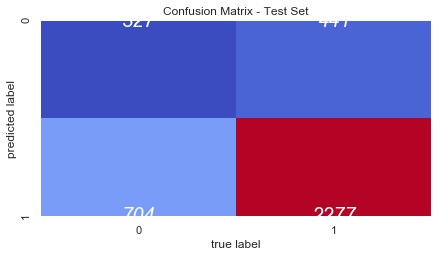

In [72]:
cm_test = confusion_matrix(y_test, y_test_pred)

annot_kws={'fontsize':20, 
           'fontstyle':'italic',  
           'color':"w",
           'alpha':1, 
           'rotation':"horizontal",
           'verticalalignment':'center'}

f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(cm_test.T, cmap="coolwarm", square=True, annot = True, fmt='d', annot_kws = annot_kws, cbar=False,
            xticklabels=(0,1),
            yticklabels=(0,1))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Test Set')

#### 2. NAIVE BAYES

In [73]:
gnb = GaussianNB()
gnb

GaussianNB(priors=None, var_smoothing=1e-09)

In [74]:
gnb = GaussianNB()

#Train NAIVE BAYES ON THE TRAIN SET
gnb = gnb.fit(X_train, y_train)

print("Accuracy on training set:",  gnb.score(X_train, y_train))

# predictions for train set
y_train_pred = gnb.predict(X_train)

Accuracy on training set: 0.6989505514051939


In [75]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

         0.0       0.44      0.28      0.34      3166
         1.0       0.75      0.86      0.80      8078

    accuracy                           0.70     11244
   macro avg       0.60      0.57      0.57     11244
weighted avg       0.67      0.70      0.67     11244



Text(0.5, 1, 'Confusion Matrix - Train Set')

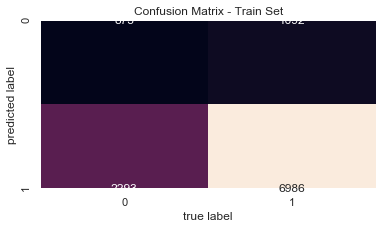

In [76]:
cm_test = confusion_matrix(y_train, y_train_pred)

sns.heatmap(cm_test.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(0,1),
            yticklabels=(0,1))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Train Set')

In [77]:
# predictions for test set
y_test_pred = gnb.predict(X_test)

print("Accuracy on test set:",  gnb.score(X_test, y_test))

Accuracy on test set: 0.696185649506535


In [78]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.42      0.26      0.32      1031
         1.0       0.75      0.86      0.80      2718

    accuracy                           0.70      3749
   macro avg       0.59      0.56      0.56      3749
weighted avg       0.66      0.70      0.67      3749



Text(0.5, 1, 'Confusion Matrix - Test Set')

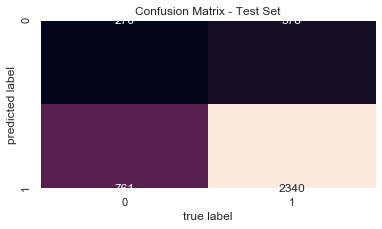

In [79]:
cm_test = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm_test.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(0,1),
            yticklabels=(0,1))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Test Set')

#### 3. DECISION TREES

In [80]:
dtc_Gini = tree.DecisionTreeClassifier() # criterion = "Gini"

dtc_Gini = dtc_Gini.fit(ex1, tgt1)

dtc_Gini

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [152]:
dot_data = tree.export_graphviz(dtc_Gini, out_file="pets.dot",
                                feature_names=fn1,
                                class_names=tn1,
                                filled=True, rounded=True,
                                special_characters=True)

## 1.3. Classification - Results and Discussion 

### Predicting AdoptionSpeed (Multiclass classification task)

*** Data balancement ***

In [88]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(examples, df['AdoptionSpeed'], random_state=0) ### data split

In [91]:
print("Number 0 adoption speed cases in the train set is: {}".format(np.count_nonzero(y_train_m == 0)))
print("Number 1 adoption speed cases in the train set is: {}".format(np.count_nonzero(y_train_m == 1)))
print("Number 2 adoption speed cases in the train set is: {}".format(np.count_nonzero(y_train_m == 2)))
print("Number 3 adoption speed cases in the train set is: {}".format(np.count_nonzero(y_train_m == 3)))
print("Number 4 adoption speed cases in the train set is: {}".format(np.count_nonzero(y_train_m == 4)))

Number 0 adoption speed cases in the train set is: 316
Number 1 adoption speed cases in the train set is: 2300
Number 2 adoption speed cases in the train set is: 3011
Number 3 adoption speed cases in the train set is: 2451
Number 4 adoption speed cases in the train set is: 3166


In [92]:
print("Number 0 adoption speed cases in the test set is: {}".format(np.count_nonzero(y_test_m == 0)))
print("Number 1 adoption speed cases in the test set is: {}".format(np.count_nonzero(y_test_m == 1)))
print("Number 2 adoption speed cases in the test set is: {}".format(np.count_nonzero(y_test_m == 2)))
print("Number 3 adoption speed cases in the test set is: {}".format(np.count_nonzero(y_test_m == 3)))
print("Number 4 adoption speed cases in the test set is: {}".format(np.count_nonzero(y_test_m == 4)))

Number 0 adoption speed cases in the test set is: 94
Number 1 adoption speed cases in the test set is: 790
Number 2 adoption speed cases in the test set is: 1026
Number 3 adoption speed cases in the test set is: 808
Number 4 adoption speed cases in the test set is: 1031


#### 1. KNN

In [93]:
knn_m = neighbors.KNeighborsClassifier(n_neighbors=3) ## 3 neighbors for starters
knn_m

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [97]:
knn_m = knn.fit(X_train_m, y_train_m)

y_train_pred_m = knn_m.predict(X_train_m)

print("Accuracy on training set:",  knn_m.score(X_train_m, y_train_m))

Accuracy on training set: 0.6085023123443615


In [98]:
print(classification_report(y_train_m,y_train_pred_m))

              precision    recall  f1-score   support

           0       0.38      0.73      0.50       316
           1       0.48      0.76      0.59      2300
           2       0.62      0.62      0.62      3011
           3       0.73      0.48      0.58      2451
           4       0.77      0.58      0.66      3166

    accuracy                           0.61     11244
   macro avg       0.60      0.63      0.59     11244
weighted avg       0.65      0.61      0.61     11244



Text(0.5, 1, 'Confusion Matrix - Train Set')

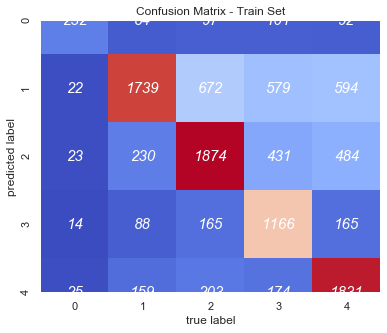

In [102]:
cm_test = confusion_matrix(y_train_m, y_train_pred_m)

annot_kws={'fontsize':15, 
           'fontstyle':'italic',  
           'color':"w",
           'alpha':1, 
           'rotation':"horizontal",
           'verticalalignment':'center'}

f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(cm_test.T, cmap="coolwarm", square=True, annot = True, fmt='d', annot_kws = annot_kws, cbar=False,
            xticklabels=(0,1,2,3,4),
            yticklabels=(0,1,2,3,4))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Train Set')

In [99]:
y_test_pred_m = knn.predict(X_test_m)

print("Accuracy on test set:",  knn.score(X_test_m, y_test_m))

Accuracy on test set: 0.30488130168044814


In [100]:
print(classification_report(y_test_m,y_test_pred_m))

              precision    recall  f1-score   support

           0       0.06      0.12      0.08        94
           1       0.25      0.41      0.31       790
           2       0.32      0.31      0.31      1026
           3       0.32      0.20      0.25       808
           4       0.43      0.32      0.36      1031

    accuracy                           0.30      3749
   macro avg       0.27      0.27      0.26      3749
weighted avg       0.33      0.30      0.31      3749



Text(0.5, 1, 'Confusion Matrix - Test Set')

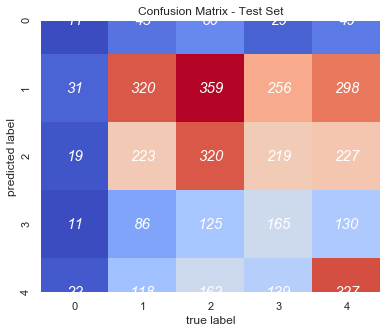

In [103]:
cm_test = confusion_matrix(y_test_m, y_test_pred_m)

annot_kws={'fontsize':15, 
           'fontstyle':'italic',  
           'color':"w",
           'alpha':1, 
           'rotation':"horizontal",
           'verticalalignment':'center'}

f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(cm_test.T, cmap="coolwarm", square=True, annot = True, fmt='d', annot_kws = annot_kws, cbar=False,
            xticklabels=(0,1,2,3,4),
            yticklabels=(0,1,2,3,4))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Test Set')

#### 2. NAIVE BAYES

#### 3. DECISION TREES

## Task 2 (Unsupervised Learning) - Charactering Adopted Pets and Adoption Speed

In this task you should **use unsupervised learning algorithms and try to characterize pets that were actually adopted and their adoption speed**. You can use:
* **Association rule mining** to find **associations between the features and the target Adoption/AdoptionSpeed**.
* **Clustering algorithms to find similar groups of pets**. Is it possible to find groups of pets with the same/similar adoption speed.
* **Be creative and define your own unsupervised analysis!** What would it be interesting to find out ?

## 2.1. Preprocessing Data for Association Rule Mining

...

## 2.2. Finding Associations

...

## 2.3 Association Rules - Results and Discussion 

...

## 2.4. Preprocessing Data for Clustering

...

## 2.5. Finding Groups

...

## 2.6. Clustering - Results and Discussion 

...

## 3. Final Comments and Conclusions

...